# Overview of Results in the Atlas Dataset

August 2019, Stephen Strowes, CAIDA / RIPE NCC



## Overview

The RIPE Atlas platform is a network measurement platform offering general access to a set of predefined network measurement types from many vantage points.

The platform runs measurements of different types, including:

* **Built-in measurements**: ongoing measurements run by all probes on the platform to various stable targets. The set of specifications includes various ping, traceroute, HTTP, DNS, and SSL measurements. The full set of built-in measurements [is described here](https://atlas.ripe.net/docs/built-in/).
* **Ongoing topology measurements**: One of the built-in measurements defined above specifically aims for topological breadth by sending traceroutes to "every routed prefix yesterday" over both IPv4 and IPv6. Every Atlas probe resolves the same DNS record which round-robins through all the potential ‘.1’ or ‘::1’ addresses given the set of routed prefixes.
* **Anchoring measurements**, ongoing measurements that target Atlas anchors with ping, traceroute, and HTTP over IPv4 and IPv6. These are further subdivided into the full-mesh of 450 anchors running measurements to each other, and a few hundred other probes measuring each anchor.
* **User-defined measurements (UDMs)**, permitted from arbitrary origins to arbitrary targets for most types of measurement. HTTP measurements are restricted to very few users.

The measurements are delineated in different ways:

* **Measurement Specification IDs**: Every measurement specification has a unique integer ID. Measurement IDs less than 1,000,000 are built-ins; all user-defined measurements have IDs greater than 1,000,000.
* **Anchoring measurements** are generated with specification IDs higher than 1,000,000 but can be identified from the tags on the measurements themselves. These can be described [with some work via the API](https://atlas.ripe.net/docs/api/v2/reference/#!/anchor-measurements/Anchor_Measurement_List_GET) or in the [daily measurement "meta" dumps](https://ftp.ripe.net/ripe/atlas/measurements/).


## Target Diversity

## Source Diversity

Topology measurements: Given the lack of control with this method, different sources are likely to be used for the same target over time if the target is repeatedly present in the list.


## List of dimensions

* Public measurements
  * Topology
  * Other Built-ins
  * Anchoring
  * User-defined
* All measurements
  * Topology
  * Other Built-ins
  * Anchoring
  * User-defined


Can I define a table that includes:
* hour
* prb_id
* af
* msm_id
* msm_class
* public/private
* oneoff
* src_address
* dst_address
* dst_name
* count

* Target diversity for each of the above

* Later: ASN diversity
* Later: IPv4 and IPv6


### Public vs Private

From 2019-06-01 00:00:00 through 2019-08-26 18:59:59:
* 8.42bn traceroute results total


## How many traceroutes?

In [55]:
%%bigquery atlas_results_per_day

SELECT
  DATETIME_TRUNC(DATETIME(startTime), HOUR) as hour,
  COUNT(startTime)                          as count,
  af

FROM    `data-test-194508.prod.traceroute_atlas_prod`
WHERE    startTime >= "2019-08-01T00:00:00"
AND      startTime  < "2019-09-01T00:00:00"
GROUP BY hour, af
ORDER BY hour

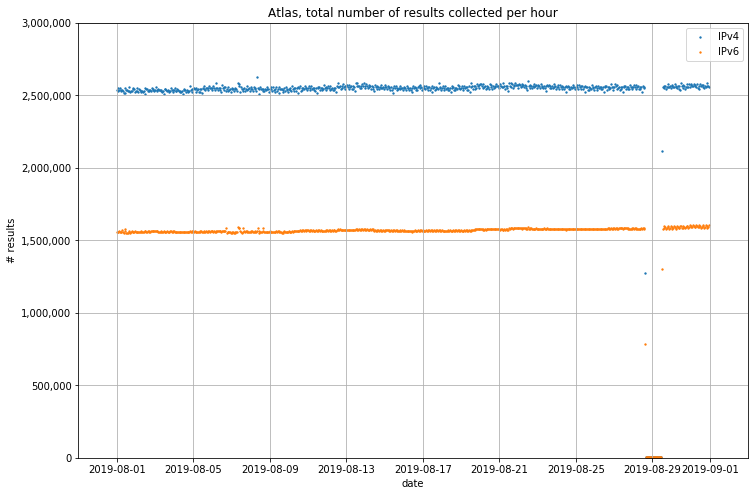

In [62]:
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()

for af in [4, 6]:
        grp   = atlas_results_per_day[(atlas_results_per_day['af'] == af)]
        label = "IPv" + str(af)
        plt.scatter(grp['hour'], grp['count'], label=label, s=1.8)

ax.grid(True)
ax.set_title("Atlas, total number of results collected per hour")
ax.set_xlabel('date')
ax.set_ylabel('# results')
ax.legend(loc='best')
ax.set_xlim(left="2019-07-30", right="2019-09-03")
ax.set_ylim(bottom=0, top=3000000)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

## Composition of Results Corpus

Want: an overview of which results types contribute

In [2]:
%load_ext google.cloud.bigquery


In [83]:
%%bigquery public_private

SELECT    ts, af, public, msm_class, COUNT(*) as count
FROM     `data-test-194508.atlas_results_meta.msm_types`
GROUP BY  ts, af, public, msm_class, public
ORDER BY  ts ASC

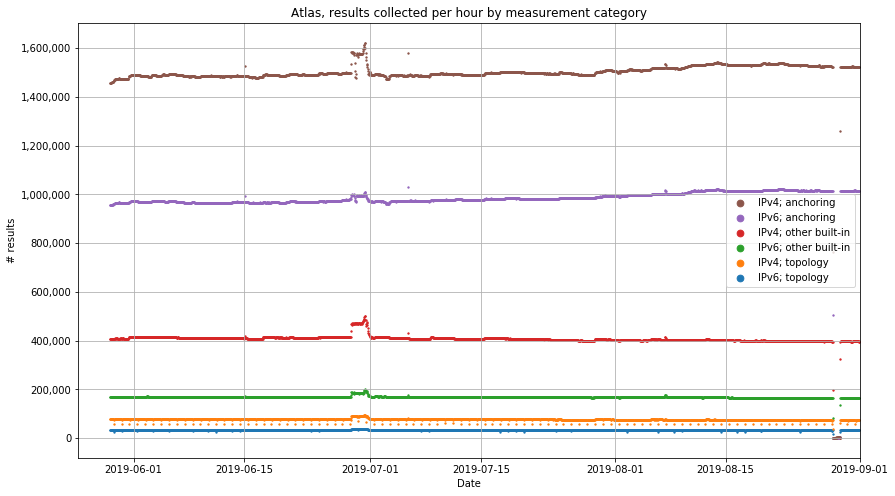

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]
fig, ax = plt.subplots()

#------------------------------------------------------------------------------
# Plot built-ins, IPv6/4
for af in [6, 4]:
        grp   = public_private[((public_private['msm_class'] == "topology*.dyndns.atlas.ripe.net UDP") | (public_private['msm_class'] == "topology*.dyndns.atlas.ripe.net ICMP")) & (public_private['af'] == af)]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; topology"
        plt.scatter(grp['ts'], grp['count'], label=label, s=1.8)

        #------------------------------------------------------------------------------
for af in [6, 4]:
        grp   = public_private[
            ((public_private['msm_class'] == "*.root-servers.net") | (public_private['msm_class'] == "ctr-*.atlas.ripe.net")) &
            (public_private['af'] == af)
        ]
        
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; other built-in"
        plt.scatter(grp['ts'], grp['count'], label=label, s=1.8)
        
for af in [6, 4]:
        grp   = public_private[
            ((public_private['msm_class'] == "anchoring (probes)") | (public_private['msm_class'] == "anchoring (mesh)")) &
            (public_private['af'] == af)
        ]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; anchoring"
        plt.scatter(grp['ts'], grp['count'], label=label, s=1.8)

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('# results')
ax.set_xlim(left="2019-05-25", right="2019-09-01")
ax.set_title("Atlas, results collected per hour by measurement category")
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()
# just gonna hack this manually
# ['IPv6; topology', 'IPv4; topology', 'IPv6; other built-in', 'IPv4; other built-in', 'IPv6; anchoring', 'IPv4; anchoring']
labels  = [  labels[5],  labels[4],  labels[3],  labels[2],  labels[1],  labels[0] ]
handles = [ handles[5], handles[4], handles[3], handles[2], handles[1], handles[0] ]

ax.legend(handles, labels, loc='best', markerscale=5)
plt.show()


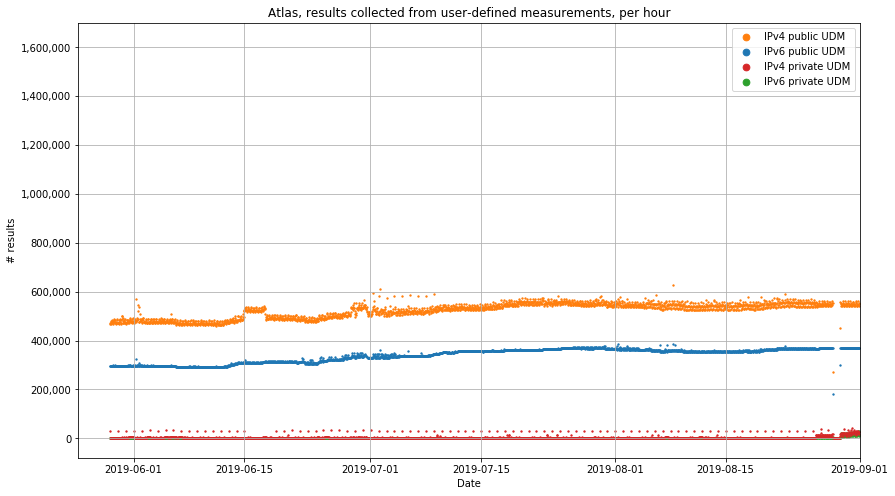

In [97]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]
fig, ax = plt.subplots()

# Plot UDMs
for p in [ True, False ]:
    for af in [ 6, 4 ]:
        grp   = public_private[(public_private['msm_class'] == "user-defined") & (public_private['public'] == p) & (public_private['af'] == af) ]
        #    grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        if p == True:
            label = "IPv" + str(af) +" public UDM"
        else:
            label = "IPv" + str(af) +" private UDM"
        plt.scatter(grp['ts'], grp['count'], label=label, s=1.8)

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('# results')
ax.set_xlim(left="2019-05-25", right="2019-09-01")
ax.set_ylim(bottom=-80000, top=1700000)
ax.set_title("Atlas, results collected from user-defined measurements, per hour")
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()

# just gonna hack this manually
# ['IPv6 public UDM', 'IPv4 public UDM', 'IPv6 private UDM', 'IPv4 private UDM']
labels  = [  labels[1],  labels[0],  labels[3],  labels[2] ]
handles = [ handles[1], handles[0], handles[3], handles[2], handles[1], handles[0] ]

ax.legend(handles, labels, loc='best', markerscale=5)
plt.show()


## Results per measurement category



In [29]:
%%bigquery msm_class_result_counts
SELECT * FROM `data-test-194508.sds_test.msm_class_result_counts` ORDER BY ts


In [99]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.dates as dates
import matplotlib.pyplot as plt

grp   = msm_class_result_counts[
    ((msm_class_result_counts['msm_class'] == "user-defined")) &
    (msm_class_result_counts['af'] == 4)]


NameError: name 'msm_class_result_counts' is not defined

# Target Diversity

The above refers to the number of measurement results (i.e., the number of traceroutes returned); it says nothing of the targets measured or the hops travered.

First, it's easy to count the number of targets each type of measurement used:

In [100]:
%%bigquery target_counts

SELECT
  ts,
  af,
  msm_class,
  public,
  COUNT(DISTINCT dst_address) as count
FROM
  `data-test-194508.atlas_results_meta.msm_types`
GROUP BY
  ts, af, public, msm_class
ORDER BY ts


Let's break this down as before, into measurements run by the system (built-ins and anchoring measurements), followed by user-defined measurements, in the form of time-series:


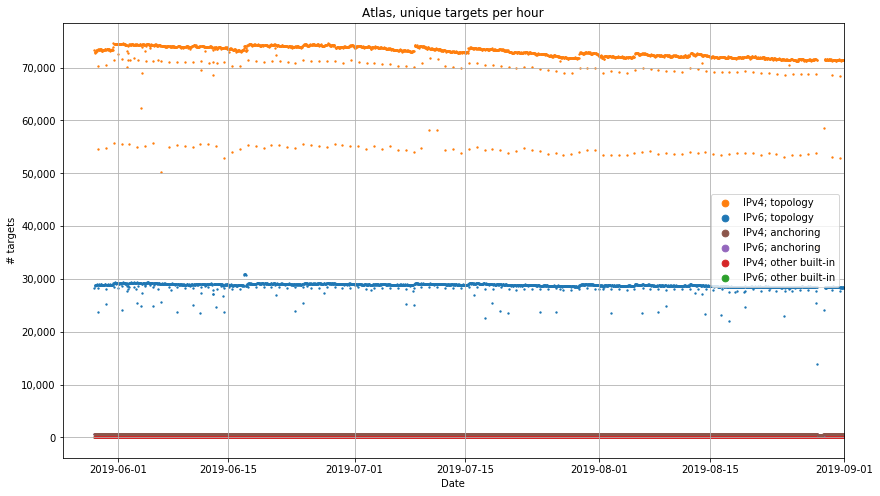

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]
fig, ax = plt.subplots()

#------------------------------------------------------------------------------
# Plot built-ins, IPv6/4
for af in [6, 4]:
        grp   = target_counts[((target_counts['msm_class'] == "topology*.dyndns.atlas.ripe.net UDP") | (target_counts['msm_class'] == "topology*.dyndns.atlas.ripe.net ICMP")) & (target_counts['af'] == af)]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; topology"
        plt.scatter(grp['ts'], grp['count'], label=label, s=1.8)

        #------------------------------------------------------------------------------
for af in [6, 4]:
        grp   = target_counts[
            ((target_counts['msm_class'] == "*.root-servers.net") | (target_counts['msm_class'] == "ctr-*.atlas.ripe.net")) &
            (target_counts['af'] == af)
        ]
        
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; other built-in"
        plt.scatter(grp['ts'], grp['count'], label=label, s=1.8)
        
for af in [6, 4]:
        grp   = target_counts[
            ((target_counts['msm_class'] == "anchoring (probes)") | (target_counts['msm_class'] == "anchoring (mesh)")) &
            (target_counts['af'] == af)
        ]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; anchoring"
        plt.scatter(grp['ts'], grp['count'], label=label, s=1.8)
 

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('# targets')
ax.set_xlim(left="2019-05-25", right="2019-09-01")
ax.set_title("Atlas, unique targets per hour")
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()
# just gonna hack this manually
# ['IPv6; topology', 'IPv4; topology', 'IPv6; other built-in', 'IPv4; other built-in', 'IPv6; anchoring', 'IPv4; anchoring']
labels  = [  labels[1],  labels[0],  labels[5],  labels[4],  labels[3],  labels[2] ]
handles = [ handles[1], handles[0], handles[5], handles[4], handles[3], handles[2] ]

ax.legend(handles, labels, loc='best', markerscale=5)

plt.show()

Although the topology measurements generate relatively few results, the range of targets is (by definition), large: up to around 75,000 distinct IPv4 addresses per hour, and up to 30,000 distinct IPv6 addresses per hour. The other built-in measurements target very specific addresses, and so all cluster towards the bottom of the y-axis.


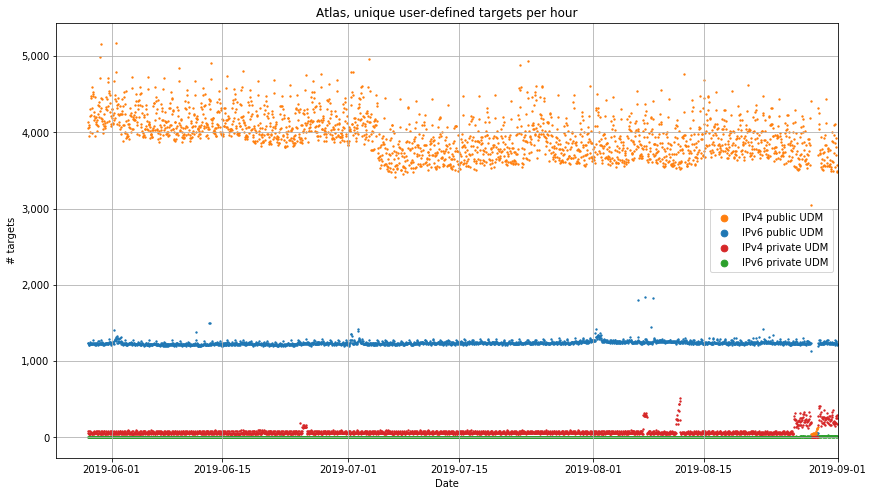

In [116]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]
fig, ax = plt.subplots()

# Plot UDMs
for p in [ True, False ]:
    for af in [ 6, 4 ]:
        grp   = target_counts[(target_counts['msm_class'] == "user-defined") & (target_counts['public'] == p) & (target_counts['af'] == af) ]
        #    grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        if p == True:
            label = "IPv" + str(af) +" public UDM"
        else:
            label = "IPv" + str(af) +" private UDM"
        plt.scatter(grp['ts'], grp['count'], label=label, s=1.8)

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('# targets')
ax.set_xlim(left="2019-05-25", right="2019-09-01")
ax.set_title("Atlas, unique user-defined targets per hour")
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()

# just gonna hack this manually
# ['IPv6 public UDM', 'IPv4 public UDM', 'IPv6 private UDM', 'IPv4 private UDM']
labels  = [  labels[1],  labels[0],  labels[3],  labels[2] ]
handles = [ handles[1], handles[0], handles[3], handles[2], handles[1], handles[0] ]

ax.legend(handles, labels, loc='best', markerscale=5)

plt.show()



User-defined measurements are quite different: there appears to be distinct daily patterns, in particular in the IPv4 measurements, and the number of distinct IPv4 targets observed is around 4,000 per hour. The volume of results returned from measurements is quite stable, in particular in the IPv6 case.


### Target ASNs

In [134]:
%%bigquery atlas_asn_counts

SELECT *
FROM `data-test-194508.atlas_results_meta.msm_types_asn_origins`

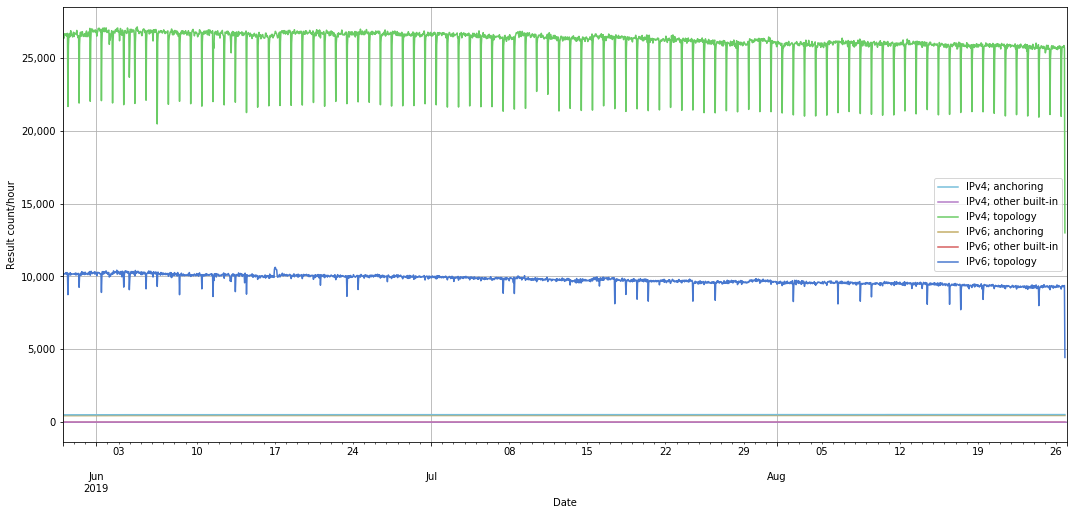

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]
fig, ax = plt.subplots()

#------------------------------------------------------------------------------
# Plot built-ins, IPv6/4
for af in [6, 4]:
        grp   = atlas_asn_counts[((atlas_asn_counts['msm_class'] == "topology*.dyndns.atlas.ripe.net UDP") | (atlas_asn_counts['msm_class'] == "topology*.dyndns.atlas.ripe.net ICMP")) & (atlas_asn_counts['af'] == af)]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; topology"
        #print(label)
        #print(grp)
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)

        #------------------------------------------------------------------------------
for af in [6, 4]:
        grp   = atlas_asn_counts[
            ((atlas_asn_counts['msm_class'] == "*.root-servers.net") | (atlas_asn_counts['msm_class'] == "ctr-*.atlas.ripe.net")) &
            (atlas_asn_counts['af'] == af)
        ]
        
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; other built-in"
        #print(label)
        #print(grp)
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)
        
for af in [6, 4]:
        grp   = atlas_asn_counts[
            ((atlas_asn_counts['msm_class'] == "anchoring (probes)") | (atlas_asn_counts['msm_class'] == "anchoring (mesh)")) &
            (atlas_asn_counts['af'] == af)
        ]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; anchoring"
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)
 
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Result count/hour')
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc='best')
plt.show()


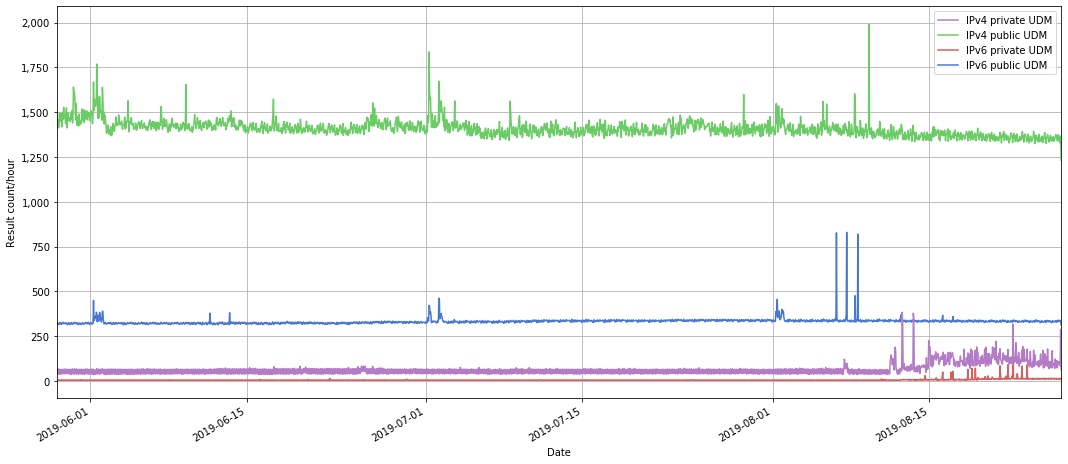

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]
fig, ax = plt.subplots()

# Plot UDMs
for p in [ True, False ]:
    for af in [ 6, 4 ]:
        grp   = atlas_asn_counts[(atlas_asn_counts['msm_class'] == "user-defined") & (atlas_asn_counts['public'] == p) & (atlas_asn_counts['af'] == af) ]
        #    grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        if p == True:
            label = "IPv" + str(af) +" public UDM"
        else:
            label = "IPv" + str(af) +" private UDM"
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Result count/hour')
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc='best')
plt.show()


**To fix**:

the dip may not be fewer targets, but is more likely because I'm using an old routing table for the whole thing.

## IPs, ASNs observed

In [51]:
%%bigquery atlas_ip_prb_distrib_day

WITH foo AS
(
  select  af, prbId, rh.from as ip
  from   `data-test-194508.prod.traceroute_atlas_prod`, unnest(hops), unnest(resultHops) rh
  WHERE   startTime >= "2019-08-01T00:00:00" AND startTime < "2019-08-02T00:00:00"
),
distribution AS
(
  SELECT   prbId, af, ARRAY_LENGTH(ARRAY_AGG(distinct ip)) num_ips
  FROM     foo
  GROUP BY prbId, af
),
counts AS
(
  SELECT   af, COUNT(*) as num_prbs, num_ips
  FROM     distribution
  GROUP BY af, num_ips
)

SELECT af, SUM(num_prbs) AS num_prbs, CAST(num_ips / 50  AS INT64) * 50 AS num_ips
FROM   counts
GROUP BY af, num_ips
ORDER BY num_ips, num_prbs

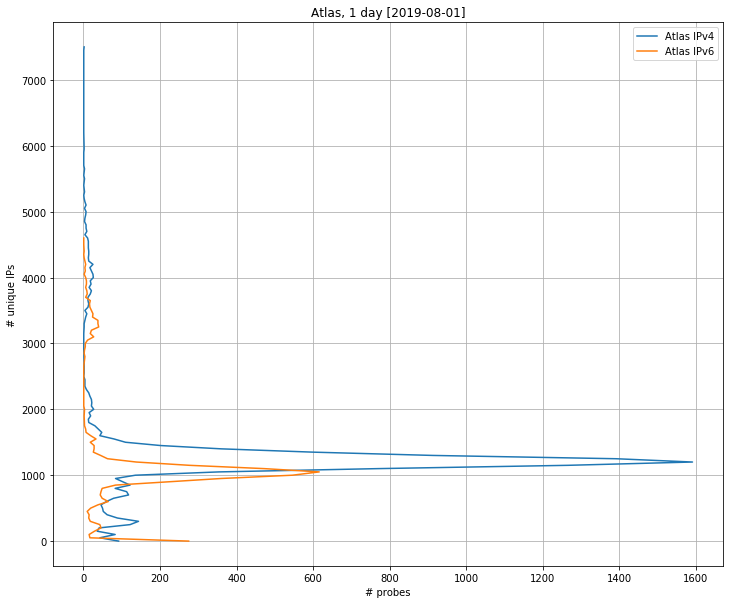

In [57]:
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 10]
fig, ax = plt.subplots()
#ax = fig.add_subplot()

for af in [4, 6]:
        grp   = atlas_ip_prb_distrib_day[(atlas_ip_prb_distrib_day['af'] == af)]
        label = "Atlas IPv" + str(af)
        
        plt.plot(grp['num_prbs'], grp['num_ips'], label=label)


ax.grid(True)
ax.set_title("Atlas, 1 day [2019-08-01]")
ax.set_xlabel('# probes')
ax.set_ylabel('# unique IPs')
ax.legend(loc='best')

In [26]:
%%bigquery atlas_ip_prb_distrib_week

WITH foo AS
(
  select  af, prbId, rh.from as ip
  from   `data-test-194508.prod.traceroute_atlas_prod`, unnest(hops), unnest(resultHops) rh
  WHERE   startTime >= "2019-08-01T00:00:00" AND startTime < "2019-08-08T00:00:00"
),
distribution AS
(
  SELECT   prbId, af, ARRAY_LENGTH(ARRAY_AGG(distinct ip)) num_ips
  FROM     foo
  GROUP BY prbId, af
),
counts AS
(
  SELECT   af, COUNT(*) as num_prbs, num_ips
  FROM     distribution
  GROUP BY af, num_ips
)

SELECT af, SUM(num_prbs) AS num_prbs, CAST(num_ips / 50  AS INT64) * 50 AS num_ips
FROM   counts
GROUP BY af, num_ips
ORDER BY num_ips, num_prbs

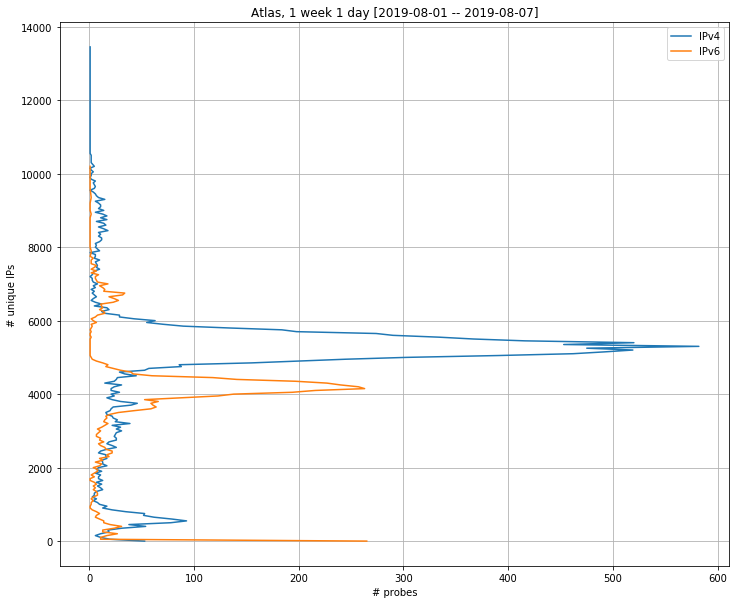

In [56]:
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 10]
fig, ax = plt.subplots()

for af in [4, 6]:
        grp   = atlas_ip_prb_distrib_week[(atlas_ip_prb_distrib_week['af'] == af)]
        label = "IPv" + str(af)
        plt.plot(grp['num_prbs'], grp['num_ips'], label=label)

ax.grid(True)
ax.set_title("Atlas, 1 week 1 day [2019-08-01 -- 2019-08-07]")
ax.set_xlabel('# probes')
ax.set_ylabel('# unique IPs')
ax.legend(loc='best')

## Topology Address Collection

How long does it take to sweep a full table?

In [22]:
%%bigquery v4_topology_addr_first_seen

WITH times AS (
  SELECT  min(startTime) as first_ts, dstAddress
  from   `data-test-194508.prod.traceroute_atlas_prod`
  WHERE  (msmId = 5051 OR msmId = 5151)
  AND     startTime >= "2019-08-01T00:00:00"
  AND     startTime < "2019-08-05T00:00:00"
  GROUP BY dstAddress
),
counts AS (
  SELECT   (UNIX_SECONDS(first_ts) - UNIX_SECONDS("2019-08-01T00:00:00")) as ts_delta, first_ts, count(first_ts) AS count
  FROM     times
  GROUP BY first_ts
)

SELECT ts_delta, first_ts, count, SUM(count) OVER(ORDER BY ts_delta) as total
FROM   counts
ORDER BY first_ts

In [4]:
%%bigquery v4_table_size
SELECT COUNT(DISTINCT prefix) AS c FROM `data-test-194508.sds_test.rib_20190829_0000` WHERE af = 4

In [23]:
%%bigquery v6_topology_addr_first_seen

WITH times AS (
  SELECT  min(startTime) as first_ts, dstAddress
  from   `data-test-194508.prod.traceroute_atlas_prod`
  WHERE  (msmId = 6052 OR msmId = 6152)
  AND     startTime >= "2019-08-01T00:00:00"
  AND     startTime < "2019-08-05T00:00:00"
  GROUP BY dstAddress
),
counts AS (
  SELECT   (UNIX_SECONDS(first_ts) - UNIX_SECONDS("2019-08-01T00:00:00")) as ts_delta, first_ts, count(first_ts) AS count
  FROM     times
  GROUP BY first_ts
)

SELECT ts_delta, first_ts, count, SUM(count) OVER(ORDER BY ts_delta) as total
FROM   counts
ORDER BY first_ts

In [6]:
%%bigquery v6_table_size
SELECT COUNT(DISTINCT prefix) AS c FROM `data-test-194508.sds_test.rib_20190829_0000` WHERE af = 6

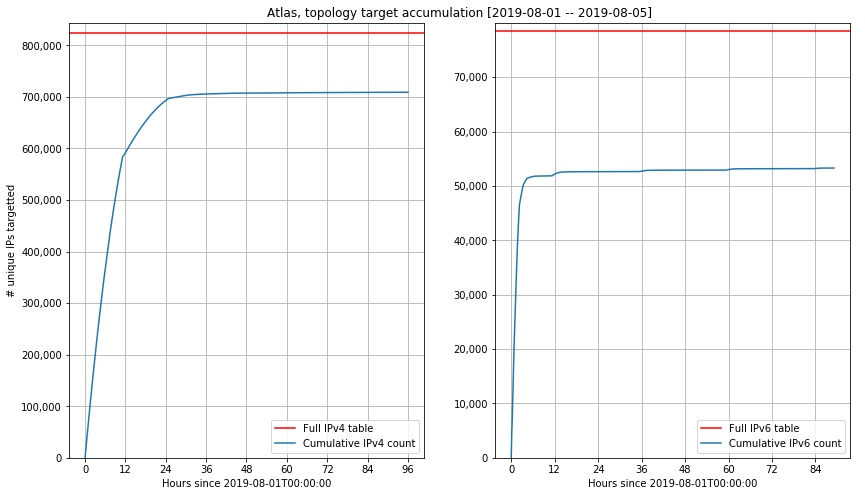

,ts_delta,first_ts,count,total
0,0,2019-08-01 00:00:00+00:00,20,20
1,1,2019-08-01 00:00:01+00:00,18,38
2,2,2019-08-01 00:00:02+00:00,22,60
3,3,2019-08-01 00:00:03+00:00,27,87
4,4,2019-08-01 00:00:04+00:00,27,114
5,5,2019-08-01 00:00:05+00:00,16,130
6,6,2019-08-01 00:00:06+00:00,21,151
7,7,2019-08-01 00:00:07+00:00,20,171
8,8,2019-08-01 00:00:08+00:00,25,196
9,9,2019-08-01 00:00:09+00:00,25,221


In [36]:
import arrow
import numpy as np
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]
fig, ax = plt.subplots()
#ax.axis('off')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', which='both', top='off', bottom='off', left='off', right='off', length=0)
#ax.get_yaxis().set_visible(False)
#ax.get_xaxis().set_visible(False)
ax.set_title("Atlas, topology target accumulation [2019-08-01 -- 2019-08-05]")

ticks = np.arange(0, 604800, 43200)

ax1 = fig.add_subplot(1,2,1)
ax1.set_xticks(ticks)
ax1.grid(True)
ax1.set_xlabel('Hours since 2019-08-01T00:00:00')
ax1.get_xaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/3600), ','))
)
ax1.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)
# Set top of plot and draw horizontal line
ax1.set_ylim(bottom=0,top=v4_table_size['c'][0]+20000)
ax1.axhline(y=v4_table_size['c'][0], xmin=0.0, xmax=1.0, color='r', label="Full IPv4 table")
plt.plot(v4_topology_addr_first_seen['ts_delta'], v4_topology_addr_first_seen['total'], label="Cumulative IPv4 count")
ax1.legend(loc='best')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xticks(ticks)
ax2.grid(True)
ax2.set_xlabel('Hours since 2019-08-01T00:00:00')
ax2.get_xaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/3600), ','))
)
ax2.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)
ax2.set_ylim(bottom=0,top=v6_table_size['c'][0]+1500)
ax2.axhline(y=v6_table_size['c'][0], xmin=0.0, xmax=1.0, color='r', label="Full IPv6 table")

plt.plot(v6_topology_addr_first_seen['ts_delta'], v6_topology_addr_first_seen['total'], label="Cumulative IPv6 count")
ax2.legend(loc='best')

ax1.set_ylabel('# unique IPs targetted')
plt.show()

v4_topology_addr_first_seen.head(20)

## User defined target accumulation

In [134]:
%%bigquery v4_udm_addr_first_seen

WITH times AS (
  SELECT  min(startTime) as first_ts, dstAddress
  from   `data-test-194508.prod.traceroute_atlas_prod`
  WHERE  (msmId > 1000000)
  AND     af = 4
  AND     startTime >= "2019-07-01T00:00:00"
  AND     startTime < "2019-09-01T00:00:00"
  GROUP BY dstAddress
),
counts AS (
  SELECT   (UNIX_SECONDS(first_ts) - UNIX_SECONDS("2019-07-01T00:00:00")) as ts_delta, first_ts, count(first_ts) AS count
  FROM     times
  GROUP BY first_ts
)

SELECT ts_delta, first_ts, count, SUM(count) OVER(ORDER BY ts_delta) as total
FROM   counts
ORDER BY first_ts

In [135]:
%%bigquery v6_udm_addr_first_seen

WITH times AS (
  SELECT  min(startTime) as first_ts, dstAddress
  from   `data-test-194508.prod.traceroute_atlas_prod`
  WHERE  (msmId > 1000000)
  AND     af = 6
  AND     startTime >= "2019-07-01T00:00:00"
  AND     startTime < "2019-09-01T00:00:00"
  GROUP BY dstAddress
),
counts AS (
  SELECT   (UNIX_SECONDS(first_ts) - UNIX_SECONDS("2019-07-01T00:00:00")) as ts_delta, first_ts, count(first_ts) AS count
  FROM     times
  GROUP BY first_ts
)

SELECT ts_delta, first_ts, count, SUM(count) OVER(ORDER BY ts_delta) as total
FROM   counts
ORDER BY first_ts

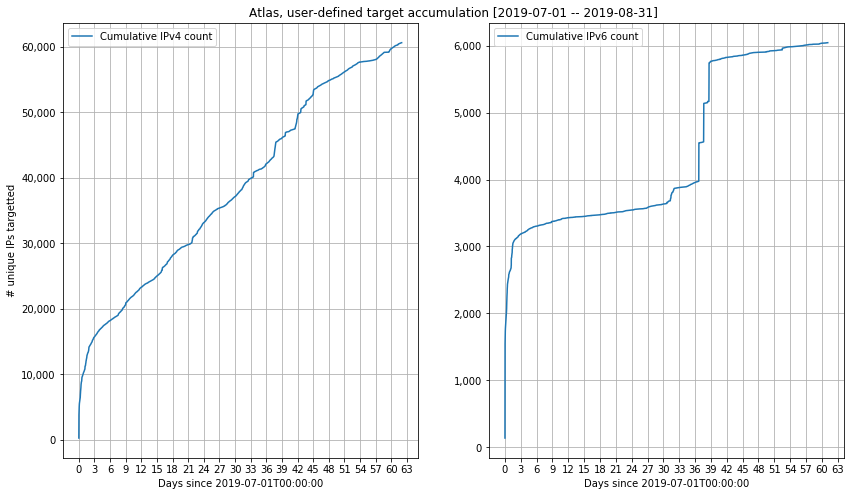

,ts_delta,first_ts,count,total
0,0,2019-08-01 00:00:00+00:00,20,20
1,1,2019-08-01 00:00:01+00:00,18,38
2,2,2019-08-01 00:00:02+00:00,22,60
3,3,2019-08-01 00:00:03+00:00,27,87
4,4,2019-08-01 00:00:04+00:00,27,114
5,5,2019-08-01 00:00:05+00:00,16,130
6,6,2019-08-01 00:00:06+00:00,21,151
7,7,2019-08-01 00:00:07+00:00,20,171
8,8,2019-08-01 00:00:08+00:00,25,196
9,9,2019-08-01 00:00:09+00:00,25,221


In [139]:
import arrow
import numpy as np
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]
fig, ax = plt.subplots()
#ax.axis('off')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', which='both', top='off', bottom='off', left='off', right='off', length=0)
#ax.get_yaxis().set_visible(False)
#ax.get_xaxis().set_visible(False)
ax.set_title("Atlas, user-defined target accumulation [2019-07-01 -- 2019-08-31]")

ticks = np.arange(0, 6300000, 259200)

ax1 = fig.add_subplot(1,2,1)
ax1.set_xticks(ticks)
ax1.grid(True)
ax1.set_xlabel('Days since 2019-07-01T00:00:00')
ax1.get_xaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/86400), ','))
)
ax1.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)
# Set top of plot and draw horizontal line
plt.plot(v4_udm_addr_first_seen['ts_delta'], v4_udm_addr_first_seen['total'], label="Cumulative IPv4 count")
ax1.legend(loc='best')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xticks(ticks)
ax2.grid(True)
ax2.set_xlabel('Days since 2019-07-01T00:00:00')
ax2.get_xaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/86400), ','))
)
ax2.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)

plt.plot(v6_udm_addr_first_seen['ts_delta'], v6_udm_addr_first_seen['total'], label="Cumulative IPv6 count")
ax2.legend(loc='best')

ax1.set_ylabel('# unique IPs targetted')
plt.show()

v4_topology_addr_first_seen.head(20)

## Responding address accumulation

In [142]:
%%bigquery v4_all_responding_addr_first_seen

WITH times AS (
  SELECT min(startTime) as first_ts, rh.from as ip
  FROM `data-test-194508.prod.traceroute_atlas_prod`, UNNEST(hops) as h, UNNEST(resultHops) as rh
  WHERE startTime >= "2019-07-01T00:00:00"
  AND   startTime <  "2019-09-01T00:00:00"
  AND   af = 4
  GROUP BY ip
),
counts AS (
  SELECT   (UNIX_SECONDS(first_ts) - UNIX_SECONDS("2019-07-01T00:00:00")) as ts_delta, first_ts, count(first_ts) AS count
  FROM     times
  GROUP BY first_ts
)

SELECT ts_delta, first_ts, count, SUM(count) OVER(ORDER BY ts_delta) as total
FROM   counts
ORDER BY first_ts


In [143]:
%%bigquery v6_all_responding_addr_first_seen

WITH times AS (
  SELECT min(startTime) as first_ts, rh.from as ip
  FROM `data-test-194508.prod.traceroute_atlas_prod`, UNNEST(hops) as h, UNNEST(resultHops) as rh
  WHERE startTime >= "2019-07-01T00:00:00"
  AND   startTime <  "2019-09-01T00:00:00"
  AND   af = 6
  GROUP BY ip
),
counts AS (
  SELECT   (UNIX_SECONDS(first_ts) - UNIX_SECONDS("2019-07-01T00:00:00")) as ts_delta, first_ts, count(first_ts) AS count
  FROM     times
  GROUP BY first_ts
)

SELECT ts_delta, first_ts, count, SUM(count) OVER(ORDER BY ts_delta) as total
FROM   counts
ORDER BY first_ts


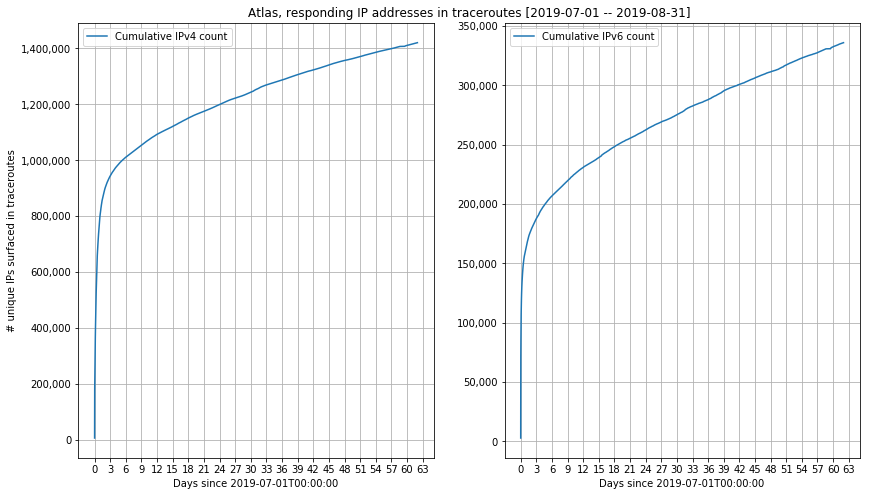

,ts_delta,first_ts,count,total
0,0,2019-08-01 00:00:00+00:00,20,20
1,1,2019-08-01 00:00:01+00:00,18,38
2,2,2019-08-01 00:00:02+00:00,22,60
3,3,2019-08-01 00:00:03+00:00,27,87
4,4,2019-08-01 00:00:04+00:00,27,114
5,5,2019-08-01 00:00:05+00:00,16,130
6,6,2019-08-01 00:00:06+00:00,21,151
7,7,2019-08-01 00:00:07+00:00,20,171
8,8,2019-08-01 00:00:08+00:00,25,196
9,9,2019-08-01 00:00:09+00:00,25,221


In [145]:
import arrow
import numpy as np
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 8]
fig, ax = plt.subplots()
#ax.axis('off')
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', which='both', top='off', bottom='off', left='off', right='off', length=0)
#ax.get_yaxis().set_visible(False)
#ax.get_xaxis().set_visible(False)
ax.set_title("Atlas, responding IP addresses in traceroutes [2019-07-01 -- 2019-08-31]")

ticks = np.arange(0, 6300000, 259200)

ax1 = fig.add_subplot(1,2,1)
ax1.set_xticks(ticks)
ax1.grid(True)
ax1.set_xlabel('Days since 2019-07-01T00:00:00')
ax1.get_xaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/86400), ','))
)
ax1.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)
# Set top of plot and draw horizontal line
plt.plot(v4_all_responding_addr_first_seen['ts_delta'], v4_all_responding_addr_first_seen['total'], label="Cumulative IPv4 count")
ax1.legend(loc='best')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xticks(ticks)
ax2.grid(True)
ax2.set_xlabel('Days since 2019-07-01T00:00:00')
ax2.get_xaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/86400), ','))
)
ax2.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ','))
)

plt.plot(v6_all_responding_addr_first_seen['ts_delta'], v6_all_responding_addr_first_seen['total'], label="Cumulative IPv6 count")
ax2.legend(loc='best')

ax1.set_ylabel('# unique IPs surfaced in traceroutes')
plt.show()

v4_topology_addr_first_seen.head(20)

In [5]:
%%bigquery atlas_ip_prb_distrib

WITH foo AS (
  select af, prbId, rh.from as f
  from   `data-test-194508.prod.traceroute_atlas_prod`, unnest(hops), unnest(resultHops) rh
  WHERE startTime > "2019-08-01" AND startTime < "2019-08-02"
),
distribution AS (
  SELECT f, af, ARRAY_LENGTH(ARRAY_AGG(distinct prbId)) AS num_prbs
  FROM   foo
  GROUP BY f, af
)

SELECT af, COUNT(*) as num_ips, num_prbs
FROM   distribution
GROUP BY af, num_prbs
ORDER BY num_ips, num_prbs

13           1
21           1
38           1
81           1
96           1
103          1
105          1
107          1
110          1
112          1
120          1
123          1
125          1
126          1
128          1
132          1
135          1
137          1
138          1
141          1
142          1
145          1
146          1
149          1
150          1
155          1
157          1
158          1
160          1
161          1
         ...  
3065      1365
3067      1518
3068      1522
3069      1542
3070      1749
3071      1766
3072      1923
3073      2060
3075      2265
3076      2446
3077      2747
3078      2883
3079      3133
3081      3352
3082      3681
3083      4048
3085      4412
3091      4982
3094      5756
3096      6523
3099      7543
3100      8764
3102     10859
3104     13341
3105     17279
3106     22996
3108     49469
3109    112163
3110    182055
3111    253786
Name: num_ips, Length: 1903, dtype: int64
13       652
21       669
38       726
81  

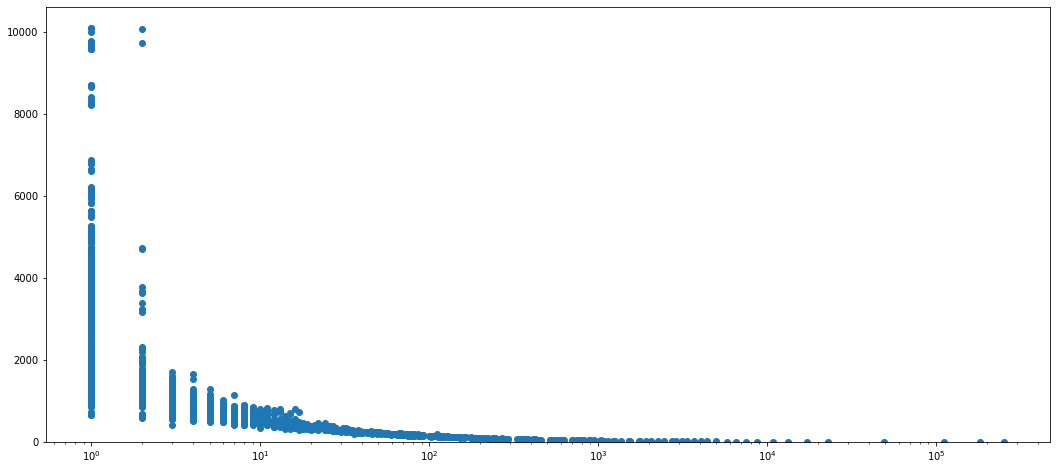

In [20]:
import matplotlib as mplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]
fig, ax = plt.subplots()

for af in [4]:
        grp   = atlas_ip_prb_distrib[(atlas_ip_prb_distrib['af'] == af)]
        #grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "Atlas IPv" + str(af)
        #print(label)
        #print(grp)
        #ax    = 
        #plt.scatter(x='num_ips', y='num_prbs', label=label)
        #print(grp['num_ips'])
        #print(grp['num_prbs'])
        
        plt.scatter(grp['num_ips'], grp['num_prbs'], label=label)
        
            #ax=ax, )

#ax.grid(True)
#ax.set_xlabel('# IP addrs')
#ax.set_ylabel('# probes')
#ax.get_yaxis().set_major_formatter(
#    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
#)
plt.ylim(ymin = 0)
#plt.yscale("log")
plt.xscale("log")

#plt.show()



In [ ]:
**To add**:

* How many results come in per measurement?
* How many probes generate results per measurement?

In [ ]:
%%bigquery v6_msm_types

SELECT *
FROM atlas_results_meta.msm_types
WHERE SUBSTR(msm_type,0,4) = "IPv6"

In [4]:
%%bigquery v4_msm_types

SELECT *
FROM atlas_results_meta.msm_types
WHERE SUBSTR(msm_type,0,4) = "IPv4"

In [5]:
%%bigquery v6_msm_types

SELECT *
FROM atlas_results_meta.msm_types
WHERE SUBSTR(msm_type,0,4) = "IPv6"

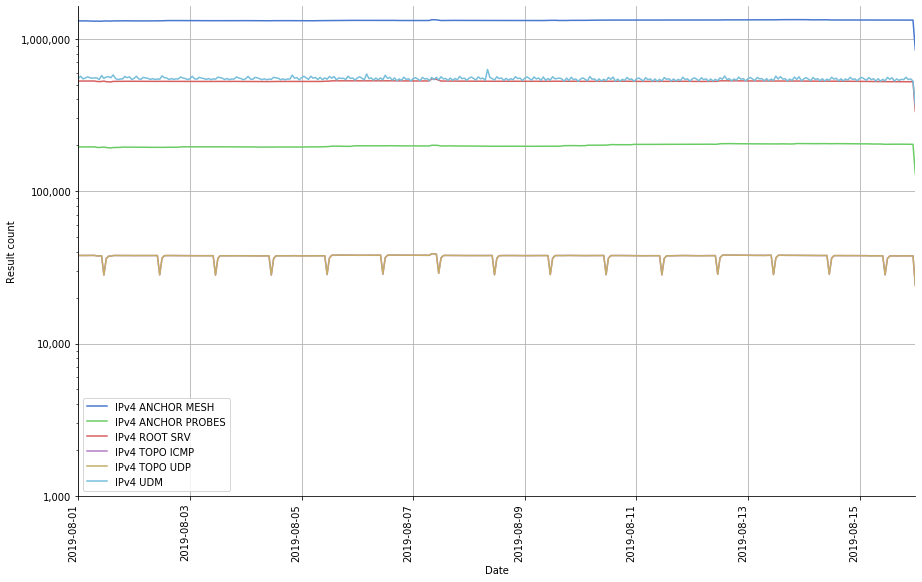

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn-muted')
fig, ax = plt.subplots()

for key, grp in v4_msm_types.groupby(['msm_type']):
    ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

    
ax.set_yscale('log')
ax.set_ylabel('Result count')

ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
#plt.box(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(bottom=1000)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(loc='best')

plt.show()


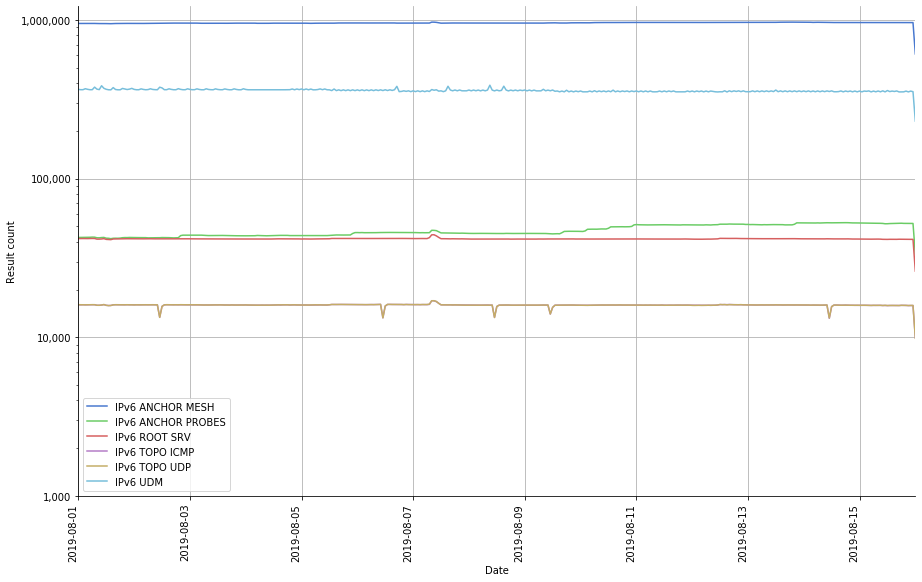

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mplotlib

plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn-muted')
fig, ax = plt.subplots()

for key, grp in v6_msm_types.groupby(['msm_type']):
    ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

ax.set_yscale('log')
ax.set_ylabel('Result count')

ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
#plt.box(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(bottom=1000)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(loc='best')

plt.show()


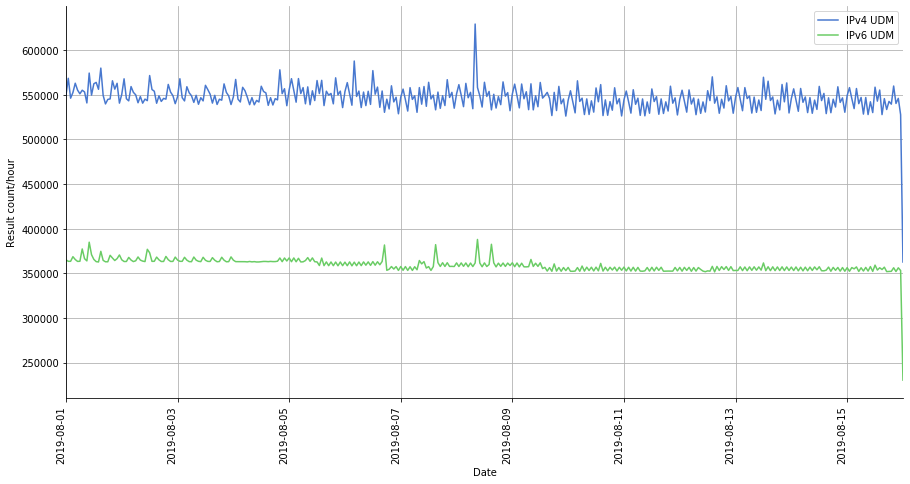

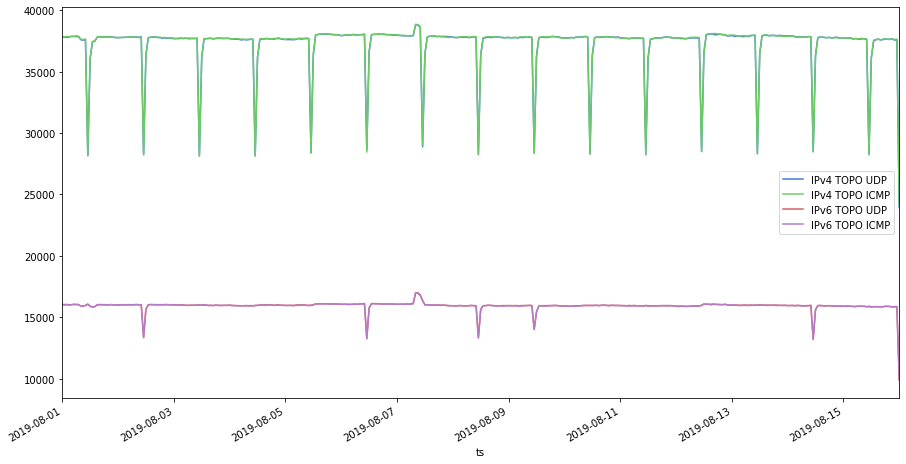

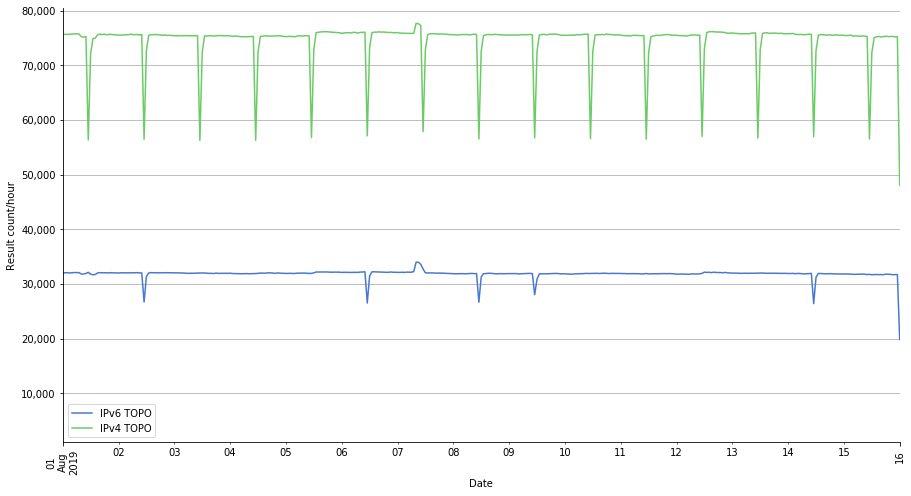

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use('seaborn-muted')
fig, ax = plt.subplots()

#--------------------------------------------------

key = 'IPv4 UDM'
grp = v4_msm_types[v4_msm_types['msm_type'] == key]
ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

key = 'IPv6 UDM'
grp = v6_msm_types[v6_msm_types['msm_type'] == key]
ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

ax.set_ylabel('Result count/hour')
ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#--------------------------------------------------

key = 'IPv4 TOPO UDP'
grp = v4_msm_types[v4_msm_types['msm_type'] == key]
ax = grp.plot(kind='line', x='ts', y='count', label=key)

key = 'IPv4 TOPO ICMP'
grp = v4_msm_types[v4_msm_types['msm_type'] == key]
ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

key = 'IPv6 TOPO UDP'
grp = v6_msm_types[v6_msm_types['msm_type'] == key]
ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

key = 'IPv6 TOPO ICMP'
grp = v6_msm_types[v6_msm_types['msm_type'] == key]
ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

#---------------------

a = v6_msm_types[v6_msm_types['msm_type'] == 'IPv6 TOPO UDP']
a = a.drop(columns="msm_type")
b = v6_msm_types[v6_msm_types['msm_type'] == 'IPv6 TOPO ICMP']
b = b.drop(columns="msm_type")
c = a.set_index("ts").add(b.set_index("ts")).reset_index()

ax = c.plot(kind='line', x='ts', y='count', label='IPv6 TOPO')

a = v4_msm_types[v4_msm_types['msm_type'] == 'IPv4 TOPO UDP']
a = a.drop(columns="msm_type")
b = v4_msm_types[v4_msm_types['msm_type'] == 'IPv4 TOPO ICMP']
b = b.drop(columns="msm_type")
c = a.set_index("ts").add(b.set_index("ts")).reset_index()

ax = c.plot(ax=ax, kind='line', x='ts', y='count', label='IPv4 TOPO')



#ax.set_yscale('log')
ax.set_ylabel('Result count/hour')
ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax.set_ylim(bottom=1000)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(loc='best')

plt.show()
